In [81]:
import math
from dataclasses import dataclass
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torchvision.utils as vutils

import xgboost as xgb
from xgboost import XGBClassifier

import wandb

## 1. Data Loading and Preprocessing

In [2]:
def time_embedding_np(t, tdim=50):
    freqs = (2 * np.pi) / np.arange(2, tdim + 1, 2)  # (tdim//2,)
    angles = np.outer(np.atleast_1d(t).astype(np.float32), freqs.astype(np.float32))
    sin_emb = np.sin(angles)
    cos_emb = np.cos(angles)
    emb = np.concatenate([sin_emb, cos_emb], axis=-1).astype(np.float32)  # (len(t), tdim)
    if emb.shape[0] == 1:
        return emb[0]
    return emb

In [10]:
def build_autoreg_rows_single(xi: np.ndarray, max_t=784, tdim=100):
    """
    xi: (784,) binary {0,1}
    Returns:
      F: (max_t, tdim + 784)
      y: (max_t,)
    Exactly matches your build_autoreg_dataset() for N=1.
    """
    xi = xi.astype(np.float32).reshape(-1)
    D = xi.shape[0]
    T = min(max_t, D)

    F = np.zeros((T, tdim + D), dtype=np.float32)
    y = np.zeros((T,), dtype=np.float32)

    for t in range(T):
        time_emb = time_embedding_np(t, tdim=tdim).astype(np.float32)

        known = np.full(D, -1.0, dtype=np.float32)
        if t > 0:
            known[:t] = xi[:t][::-1]  # reverse past pixels

        F[t, :tdim] = time_emb
        F[t, tdim:tdim + D] = known
        y[t] = xi[t]

    return F, y

class ThresholdBinarizeAndFlatten:
    def __init__(self, threshold=0.5):
        self.threshold = threshold
    def __call__(self, x):
        x = (x > self.threshold).float()
        return x.view(-1)

class StochasticBinarizeAndFlatten:
    def __call__(self, x):
        x = torch.bernoulli(x)  # Bernoulli(pixel_intensity)
        return x.view(-1)

In [12]:
# Train: deterministic (Probabilistically Binary)
train_transform = transforms.Compose([
    transforms.ToTensor(),
    ThresholdBinarizeAndFlatten(),
    # StochasticBinarizeAndFlatten()
])

# Test: deterministic threshold (fixed)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    ThresholdBinarizeAndFlatten(),
])

train_ds = datasets.MNIST("./data", train=True, download=True, transform=train_transform)
test_ds  = datasets.MNIST("./data", train=False, download=True, transform=test_transform)

def ds_to_numpy(ds):
    X = np.zeros((len(ds), 784), dtype=np.float32)
    for i in range(len(ds)):
        X[i] = ds[i][0].numpy()
    return X

n_train = 5000
n_test = 200

rng = np.random.default_rng(9515)

X_train_full = ds_to_numpy(train_ds)
X_test_full  = ds_to_numpy(test_ds)
y_train_full = train_ds.targets.cpu().numpy()
y_test_full  = test_ds.targets.cpu().numpy()
print(X_train_full.shape,X_test_full.shape)

train_idx = rng.choice(X_train_full.shape[0], size=n_train, replace=False)
test_idx  = rng.choice(X_test_full.shape[0],  size=n_test,  replace=False)

X_train = X_train_full[train_idx, :]
y_train = y_train_full[train_idx]

X_test  = X_test_full[test_idx, :]
y_test  = y_test_full[test_idx]

(60000, 784) (10000, 784)


## 2. Model


### 1. Prospective Learning MLP with Adam

In [13]:
class AutoregMLP(nn.Module):
    def __init__(self, input_dim: int, hidden: int = 512, depth: int = 6, dropout: float = 0.1):
        """
        depth = number of hidden Linear layers (all width = hidden)
        Architecture: [input -> hidden] + (depth-1)*[hidden -> hidden] + [hidden -> 1]
        """
        super().__init__()
        layers = []
        d = input_dim

        for i in range(depth):
            layers += [nn.Linear(d, hidden), nn.ReLU(), nn.Dropout(dropout)]
            d = hidden

        layers += [nn.Linear(hidden, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

def count_params(model):
    return sum(p.numel() for p in model.parameters())


In [14]:
class OnlineNNConfig:
    lr: float = 1e-4
    weight_decay: float = 1e-5
    steps_per_image: int = 1      # how many passes over the 784 rows per image
    batch_size: int = 256
    clip_grad: Optional[float] = 1.0
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

class OnlineAutoregNN:
    """
    Online trainer for your autoregressive feature formulation:
      - partial_fit_image(xi): xi is (784,) -> builds 784 rows -> Adam update
      - predict_proba_rows(F_rows): proba for rows (like xgb predict_proba)
    """
    def __init__(self, tdim: int = 100, max_t: int = 784, hidden: int = 1024, dropout: float = 0.0,
                 cfg: Optional[OnlineNNConfig] = None):
        self.tdim = tdim
        self.max_t = max_t
        self.cfg = cfg or OnlineNNConfig()

        self.input_dim = tdim + 784
        self.model = AutoregMLP(self.input_dim, hidden=hidden, depth=3, dropout=dropout).to(self.cfg.device)
        print(count_params(self.model))
        self.opt = torch.optim.AdamW(self.model.parameters(), lr=self.cfg.lr, weight_decay=self.cfg.weight_decay)

    def fit_init(self, X_init: np.ndarray, steps: int = 1) -> "OnlineAutoregNN":
        """
        Optional warm-start on a small set of images (still no replay during streaming).
        X_init: (N,784)
        """
        for _ in range(steps):
            for i in range(X_init.shape[0]):
                self.partial_fit_image(X_init[i])
        return self

    def partial_fit_image(self, xi: np.ndarray) -> float:
        """
        One online step on a single image.
        Returns mean loss over the image.
        """
        F_rows, y_rows = build_autoreg_rows_single(xi, max_t=self.max_t, tdim=self.tdim)

        X = torch.from_numpy(F_rows).to(self.cfg.device)
        y = torch.from_numpy(y_rows).to(self.cfg.device)

        self.model.train()
        n = X.shape[0]
        # bs = min(self.cfg.batch_size, n)
        bs = n

        total_loss = 0.0
        for _ in range(self.cfg.steps_per_image):
            # perm = torch.randperm(n, device=self.cfg.device)
            for j in range(0, n, bs):
                # idx = perm[j:j+bs]
                # xb = X[idx]
                # yb = y[idx]
                xb = X
                yb = y

                logits = self.model(xb)
                loss = F.binary_cross_entropy_with_logits(logits, yb)

                self.opt.zero_grad(set_to_none=True)
                loss.backward()
                if self.cfg.clip_grad is not None:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.cfg.clip_grad)
                self.opt.step()

                total_loss += float(loss.detach())

        denom = max(1, (n + bs - 1) // bs) * max(1, self.cfg.steps_per_image)
        return total_loss / denom

    @torch.no_grad()
    def predict_proba_rows(self, F_rows: np.ndarray) -> np.ndarray:
        self.model.eval()
        X = torch.from_numpy(F_rows.astype(np.float32)).to(self.cfg.device)
        logits = self.model(X)
        p = torch.sigmoid(logits).clamp(1e-6, 1 - 1e-6).detach().cpu().numpy()
        return np.stack([1.0 - p, p], axis=1)

    @torch.no_grad()
    def nll_image(self, xi: np.ndarray) -> float:
        """
        Negative log-likelihood averaged over pixels for one image.
        """
        F_rows, y = build_autoreg_rows_single(xi, max_t=self.max_t, tdim=self.tdim)
        p = self.predict_proba_rows(F_rows)[:, 1]
        p = np.clip(p, 1e-6, 1 - 1e-6)
        return float(np.sum(-(y * np.log(p) + (1 - y) * np.log(1 - p))))

### 2. Causal Transformer


In [21]:
class ARTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, ff_dim, max_seq_len, dropout=0.1):
        super(ARTransformer, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)

        pe = torch.zeros(max_seq_len, embed_dim)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('position_embedding', pe.unsqueeze(0))

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.max_seq_len = max_seq_len

    def forward(self, x):
        # x: (batch_size, seq_len)
        batch_size, seq_len = x.size()    
        
        # Embeddings
        x = self.token_embedding(x.long()) + self.position_embedding[:, :seq_len]
        x = self.dropout(x)
        
        # Causal Mask
        mask = nn.Transformer.generate_square_subsequent_mask(seq_len).to(x.device)
        
        # Transformer
        # Note: We use TransformerEncoder because we are doing AR generation on a single sequence
        # conceptually similar to a decoder-only architecture where input=output (shifted)
        x = self.transformer_encoder(x, mask=mask, is_causal=True)
        
        # Output logits
        logits = self.fc_out(x)
        return logits

In [47]:
def evaluate(model, loader, criterion):
    model.eval()
    total_nll = 0
    total_pixels = 0
    
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(DEVICE)
            batch_size = data.size(0)
            
            sos = torch.full((batch_size, 1), SOS_TOKEN, device=DEVICE)
            input_seq = torch.cat([sos, data[:, :-1]], dim=1)
            target_seq = data
            
            logits = model(input_seq)
            logits[:, :, SOS_TOKEN] = -float('inf') # set logit for SOS to -inf
            
            # Compute Cross Entropy (NLL per token)
            nll_sum = nn.functional.cross_entropy(logits.reshape(-1, VOCAB_SIZE), target_seq.long().reshape(-1), reduction='sum')
            total_nll += nll_sum.item()
            total_pixels += data.numel()
            
    # Average NLL per pixel 
    nats_per_image = total_nll / len(loader.dataset)
    
    return nats_per_image


def train_epoch(model, train_loader, test_loader, optimizer, criterion, stepsize):
    model.train()
    total_loss = 0
    test_nll_history = []
    step_history = []

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE) # (B, 784), values 0 or 1
        batch_size = data.size(0)
        
        # Create SOS token
        sos = torch.full((batch_size, 1), SOS_TOKEN, device=DEVICE)
        
        # Input: [SOS, x_0, ..., x_782] (Length 784)
        # Target: [x_0, x_1, ..., x_783] (Length 784)
        
        input_seq = torch.cat([sos, data[:, :-1]], dim=1) # [SOS, x_0, ..., x_782]
        target_seq = data # [x_0, ..., x_783]
        
        optimizer.zero_grad()
        logits = model(input_seq) # (B, 784, Vocab)
        
        # Loss
        # Reshape logits to (B*784, Vocab) and target to (B*784)
        loss = criterion(logits.reshape(-1, VOCAB_SIZE), target_seq.long().reshape(-1))
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % stepsize == 0:
            nats = evaluate(model, test_loader, criterion)
            test_nll_history.append(nats)
            step_history.append(batch_idx+1)
            print(f"step={batch_idx+1}, Loss: {loss.item():.4f}, nats: {nats: .4f}")
            # run.log({"step": batch_idx + 1,"train_loss": loss,"test_nats_per_image": nats})

    return test_nll_history, step_history

### 3. GLN

## 3. Deterministic cutoff

### Training & Evluation

#### 1. PL-MLP

In [ ]:
trainer = OnlineAutoregNN(tdim=100, max_t=784, hidden=1024, dropout=0.0)
test_nll_history = []
step_history = []
for i in range(X_train.shape[0]):
    loss = trainer.partial_fit_image(X_train[i])
    if i % 100 == 0:
        test_nll = np.mean([trainer.nll_image(X_test[k]) for k in range(X_test.shape[0])])
    # train_loss_history[i] = loss
        test_nll_history.append(test_nll)
        print(f"step={i+1} train_loss={loss:.4f} test_nll={test_nll:.4f}")
        step_history.append(i+1)

#         run.log({
#             "step": i + 1,
#             "train_loss": loss,
#             "test_nats_per_image": test_nll,
#         })

# run.finish()
np.savez("onlineMLP_autoreg_deterministic.npz",
         step = step_history,
         test_nll=test_nll_history)

3006465
step=1 train_loss=0.6756 test_nll=495.8794
step=101 train_loss=0.1624 test_nll=182.9128
step=201 train_loss=0.1599 test_nll=119.6991
step=301 train_loss=0.0905 test_nll=96.9256
step=401 train_loss=0.1697 test_nll=92.5033
step=501 train_loss=0.1209 test_nll=86.6391
step=601 train_loss=0.1153 test_nll=82.8382
step=701 train_loss=0.1128 test_nll=86.9112
step=801 train_loss=0.1311 test_nll=81.9131
step=901 train_loss=0.0864 test_nll=86.6361
step=1001 train_loss=0.0581 test_nll=94.8518
step=1101 train_loss=0.1363 test_nll=79.1936
step=1201 train_loss=0.1121 test_nll=85.0496
step=1301 train_loss=0.1739 test_nll=98.2033
step=1401 train_loss=0.1098 test_nll=91.7440
step=1501 train_loss=0.0563 test_nll=83.4344
step=1601 train_loss=0.0979 test_nll=83.7453
step=1701 train_loss=0.1383 test_nll=77.0422
step=1801 train_loss=0.1710 test_nll=95.8448
step=1901 train_loss=0.0942 test_nll=78.1148
step=2001 train_loss=0.0744 test_nll=79.0707
step=2101 train_loss=0.0780 test_nll=77.6846
step=2201 t

#### 2. Causal Transformer


In [ ]:
### Prepare for Transformer
train_ds = TensorDataset(torch.from_numpy(X_train).float(),
                         torch.from_numpy(y_train).long())
test_ds  = TensorDataset(torch.from_numpy(X_test).float(),
                         torch.from_numpy(y_test).long())

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=200, shuffle=False)

In [20]:
# Configuration
BATCH_SIZE = 1
EMBED_DIM = 256
NUM_HEADS = 8
NUM_LAYERS = 4
FF_DIM = 1024
DROPOUT = 0.1
LEARNING_RATE = 1e-4
EPOCHS = 1
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEQ_LEN = 784

print(f"Using device: {DEVICE}")

Using device: cpu


In [29]:
# Redefine model with SOS token support
VOCAB_SIZE = 3 # 0, 1, 2 (SOS)
SOS_TOKEN = 2

model = ARTransformer(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, num_heads=NUM_HEADS, 
                      num_layers=NUM_LAYERS, ff_dim=FF_DIM, max_seq_len=SEQ_LEN + 1, dropout=DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [ ]:
test_nll_history,step_history = train_epoch(model, train_loader, test_loader, optimizer, criterion,stepsize=100)
np.savez("onlineTransformer_autoreg_deterministic.npz",
         step = step_history,
         test_nll=test_nll_history)

Batch 0, Loss: 0.6864, nats:  284.8015
Batch 100, Loss: 0.1418, nats:  157.3457
Batch 200, Loss: 0.1858, nats:  149.6825
Batch 300, Loss: 0.2139, nats:  141.7739
Batch 400, Loss: 0.1642, nats:  138.8858
Batch 500, Loss: 0.1565, nats:  136.6621
Batch 600, Loss: 0.1457, nats:  136.0415
Batch 700, Loss: 0.1312, nats:  135.9590
Batch 800, Loss: 0.2127, nats:  137.8401
Batch 900, Loss: 0.1542, nats:  136.0088
Batch 1000, Loss: 0.1403, nats:  133.3868
Batch 1100, Loss: 0.1381, nats:  133.8105
Batch 1200, Loss: 0.2127, nats:  130.8758
Batch 1300, Loss: 0.1773, nats:  124.5010
Batch 1400, Loss: 0.1969, nats:  128.8225
Batch 1500, Loss: 0.1301, nats:  118.8306
Batch 1600, Loss: 0.0815, nats:  111.5213
Batch 1700, Loss: 0.1291, nats:  99.6059
Batch 1800, Loss: 0.1692, nats:  95.8087
Batch 1900, Loss: 0.1061, nats:  92.2994
Batch 2000, Loss: 0.1320, nats:  89.2150
Batch 2100, Loss: 0.0828, nats:  92.4207
Batch 2200, Loss: 0.1022, nats:  84.1042
Batch 2300, Loss: 0.1079, nats:  83.8764
Batch 2400,

#### 3. GLN

## 4. Stochastic cutoff (for training)

In [32]:
# Train: deterministic (Probabilistically Binary)
train_transform = transforms.Compose([
    transforms.ToTensor(),
    StochasticBinarizeAndFlatten()
])

# Test: deterministic threshold (fixed)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    ThresholdBinarizeAndFlatten(),
])

train_ds = datasets.MNIST("./data", train=True, download=True, transform=train_transform)
test_ds  = datasets.MNIST("./data", train=False, download=True, transform=test_transform)

def ds_to_numpy(ds):
    X = np.zeros((len(ds), 784), dtype=np.float32)
    for i in range(len(ds)):
        X[i] = ds[i][0].numpy()
    return X

n_train = 5000
n_test = 200

rng = np.random.default_rng(9515)

X_train_full = ds_to_numpy(train_ds)
X_test_full  = ds_to_numpy(test_ds)
y_train_full = train_ds.targets.cpu().numpy()
y_test_full  = test_ds.targets.cpu().numpy()
print(X_train_full.shape,X_test_full.shape)

train_idx = rng.choice(X_train_full.shape[0], size=n_train, replace=False)
test_idx  = rng.choice(X_test_full.shape[0],  size=n_test,  replace=False)

X_train = X_train_full[train_idx, :]
y_train = y_train_full[train_idx]

X_test  = X_test_full[test_idx, :]
y_test  = y_test_full[test_idx]

(60000, 784) (10000, 784)


### Training & Evaluation


#### 1. PL-MLP

In [35]:
trainer = OnlineAutoregNN(tdim=100, max_t=784, hidden=1024, dropout=0.0)
test_nll_history = []
step_history = []
for i in range(X_train.shape[0]):
    loss = trainer.partial_fit_image(X_train[i])
    if i % 100 == 0:
        test_nll = np.mean([trainer.nll_image(X_test[k]) for k in range(X_test.shape[0])])
    # train_loss_history[i] = loss
        test_nll_history.append(test_nll)
        print(f"step={i+1} train_loss={loss:.4f} test_nll={test_nll:.4f}")
        step_history.append(i+1)

#         run.log({
#             "step": i + 1,
#             "train_loss": loss,
#             "test_nats_per_image": test_nll,
#         })

# run.finish()
np.savez("onlineMLP_autoreg_stochastic.npz",
         step = step_history,
         test_nll=test_nll_history)

3006465
step=1 train_loss=0.7025 test_nll=508.5495
step=101 train_loss=0.1714 test_nll=190.8596
step=201 train_loss=0.2093 test_nll=132.5903
step=301 train_loss=0.1086 test_nll=102.4659
step=401 train_loss=0.1850 test_nll=95.6660
step=501 train_loss=0.1608 test_nll=96.5408
step=601 train_loss=0.1333 test_nll=88.8585
step=701 train_loss=0.1460 test_nll=93.4097
step=801 train_loss=0.1696 test_nll=86.6754
step=901 train_loss=0.1013 test_nll=89.4850
step=1001 train_loss=0.0616 test_nll=90.9079
step=1101 train_loss=0.1389 test_nll=84.4233
step=1201 train_loss=0.1441 test_nll=91.8141
step=1301 train_loss=0.1932 test_nll=86.0282
step=1401 train_loss=0.1488 test_nll=87.7755
step=1501 train_loss=0.0623 test_nll=89.0862
step=1601 train_loss=0.1173 test_nll=86.3303
step=1701 train_loss=0.1614 test_nll=82.3071
step=1801 train_loss=0.1757 test_nll=91.5806
step=1901 train_loss=0.1430 test_nll=87.1341
step=2001 train_loss=0.0993 test_nll=82.4898
step=2101 train_loss=0.1149 test_nll=80.3285
step=2201 

#### 2. Causal Transformer


In [36]:
train_ds = TensorDataset(torch.from_numpy(X_train).float(),
                         torch.from_numpy(y_train).long())
test_ds  = TensorDataset(torch.from_numpy(X_test).float(),
                         torch.from_numpy(y_test).long())

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=200, shuffle=False)

In [48]:
# Configuration
BATCH_SIZE = 1
EMBED_DIM = 256
NUM_HEADS = 8
NUM_LAYERS = 4
FF_DIM = 1024
DROPOUT = 0.1
LEARNING_RATE = 1e-4
EPOCHS = 1
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEQ_LEN = 784

print(f"Using device: {DEVICE}")

Using device: cpu


In [ ]:
# Redefine model with SOS token support
VOCAB_SIZE = 3 # 0, 1, 2 (SOS)
SOS_TOKEN = 2

model = ARTransformer(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, num_heads=NUM_HEADS, 
                      num_layers=NUM_LAYERS, ff_dim=FF_DIM, max_seq_len=SEQ_LEN + 1, dropout=DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

test_nll_history,step_history = train_epoch(model, train_loader, test_loader, optimizer, criterion,stepsize=100)
np.savez("onlineTransformer_autoreg_stochastic.npz",
         step = step_history,
         test_nll=test_nll_history)

step=1, Loss: 1.3127, nats:  363.6434
step=101, Loss: 0.2987, nats:  162.2774
step=201, Loss: 0.2144, nats:  151.8913
step=301, Loss: 0.2142, nats:  141.0112
step=401, Loss: 0.1822, nats:  138.1325
step=501, Loss: 0.2051, nats:  137.8953
step=601, Loss: 0.1766, nats:  135.9222
step=701, Loss: 0.2326, nats:  137.9305
step=801, Loss: 0.1228, nats:  136.8215
step=901, Loss: 0.2046, nats:  135.1664
step=1001, Loss: 0.1784, nats:  134.5679
step=1101, Loss: 0.1762, nats:  133.2640
step=1201, Loss: 0.2259, nats:  131.9509
step=1301, Loss: 0.1692, nats:  130.1510
step=1401, Loss: 0.1790, nats:  126.4380
step=1501, Loss: 0.1115, nats:  129.1767
step=1601, Loss: 0.1664, nats:  119.7920
step=1701, Loss: 0.1857, nats:  121.9653
step=1801, Loss: 0.2119, nats:  124.1568
step=1901, Loss: 0.2184, nats:  110.9108
step=2001, Loss: 0.1235, nats:  109.1203
step=2101, Loss: 0.1879, nats:  106.3575
step=2201, Loss: 0.1304, nats:  102.4842
step=2301, Loss: 0.1531, nats:  100.6364
step=2401, Loss: 0.1409, nat

#### 3. GLN

## 5. Plot Results

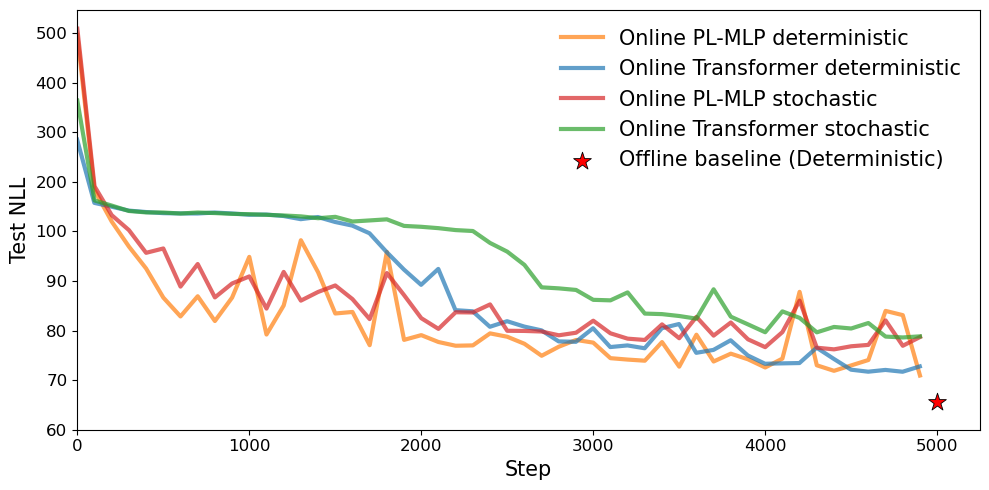

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.scale import FuncScale

files = [
    "onlineMLP_autoreg_deterministic.npz",
    "onlineTransformer_autoreg_deterministic.npz",
    "onlineMLP_autoreg_stochastic.npz",
    "onlineTransformer_autoreg_stochastic.npz",
]
labels = [
    "Online PL-MLP deterministic",
    "Online Transformer deterministic",
    "Online PL-MLP stochastic",
    "Online Transformer stochastic",
]

# colors in the SAME order as files/labels above
colors = [
    "tab:orange",  # MLP deterministic
    "tab:blue",    # Transformer deterministic
    "tab:red",     # MLP stochastic
    "tab:green",   # Transformer stochastic
]

y0 = 100.0
k = 10.0
ymin, ymax = 60, None

def forward(y):
    y = np.asarray(y, dtype=float)
    out = y.copy()
    m = y > y0
    out[m] = y0 + (y[m] - y0) / k
    return out

def inverse(yt):
    yt = np.asarray(yt, dtype=float)
    out = yt.copy()
    m = yt > y0
    out[m] = y0 + (yt[m] - y0) * k
    return out

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_yscale(FuncScale(ax, (forward, inverse)))

for f, lab, c in zip(files, labels, colors):
    d = np.load(f)
    x = d["step"]
    y = d["test_nll"]
    ax.plot(x, y, label=lab, color=c, linewidth=3,alpha = 0.7)

ax.scatter(
    [5000], [forward(np.array([65.53]))[0]],
    marker='*', s=180, c='red',
    edgecolors='k', linewidths=0.6, zorder=5,
    label='Offline baseline (Deterministic)'
)
ax.set_xticks([0,1000,2000,3000,4000,5000])
ax.set_xticklabels([str(t) for t in ax.get_xticks()])

ax.set_yticks([60, 70, 80, 90, 100, 200, 300, 400, 500])
ax.set_yticklabels([str(t) for t in ax.get_yticks()])
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

ax.set_xlim(left=0)
ax.set_ylim(ymin, forward(np.array([ymax]))[0] if ymax is not None else None)
ax.set_xlabel("Step",fontsize = 15)
ax.set_ylabel("Test NLL",fontsize = 15)
ax.legend(loc="best", frameon=False,fontsize = 15)
plt.tight_layout()
plt.show()